<a href="https://colab.research.google.com/github/1eetnals/Body-Morphometry-kidney-and-tumor/blob/main/unetr_step1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureType,
    ToTensord,
    MapTransform,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)
from monai.apps import download_and_extract

import torch

print_config()

MONAI version: 0.7.dev2134
Numpy version: 1.20.1
Pytorch version: 1.9.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: b5a2e745f93752d1dec38c6c138993c6dddd85da

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.18.1
Pillow version: 8.2.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.10.0
tqdm version: 4.59.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.8.0
pandas version: 1.2.4
einops version: 0.3.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [ ]:
root_dir='./pth_file/'

In [ ]:
train_path = '/nfs/hufsbme/moai2021/data/train/NIFTI/'
Input_folder = os.listdir(train_path)
train_files = []

for i in range(0,len(Input_folder)):
    if Input_folder[i].startswith('nifti'):
        data_file=os.listdir(train_path+Input_folder[i])
        for j in range(0,len(data_file)):
            if data_file[j].endswith('.nii.gz'):
                train_files.append(train_path+Input_folder[i]+'/'+data_file[j])

train_files.sort()
train_files

['/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training001/ct_training001.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training002/ct_training002.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training003/ct_training003.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training004/ct_training004.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training005/ct_training005.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training006/ct_training006.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training007/ct_training007.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training008/ct_training008.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training009/ct_training009.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training010/ct_training010.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training011/ct_training011.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training012/ct_training012.nii.gz',
 '/n

In [ ]:
train_label_path = '/nfs/hufsbme/moai2021/data/train/Label_NIFTI'
Input_folder = os.listdir(train_label_path)
train_label_files = []

for i in range(0,len(Input_folder)):
    if Input_folder[i].startswith('training'):
        train_label_files.append(train_label_path+'/'+Input_folder[i])

train_label_files.sort()
train_label_files

['/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training001.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training002.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training003.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training004.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training005.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training006.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training007.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training008.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training009.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training010.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training011.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training012.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training013.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training014.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/t

In [ ]:
train_ind=np.arange(0,30)
data_dicts=[
    {
        "image": train_files[idx],
        "label": train_label_files[idx],
    }
    for idx in train_ind
]

train_f=data_dicts
len(train_f)
train_f

[{'image': '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training001/ct_training001.nii.gz',
  'label': '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training001.nii.gz'},
 {'image': '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training002/ct_training002.nii.gz',
  'label': '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training002.nii.gz'},
 {'image': '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training003/ct_training003.nii.gz',
  'label': '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training003.nii.gz'},
 {'image': '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training004/ct_training004.nii.gz',
  'label': '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training004.nii.gz'},
 {'image': '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training005/ct_training005.nii.gz',
  'label': '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training005.nii.gz'},
 {'image': '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training006/ct_training006.nii.gz',
  'label': '/nfs/hufsbme/moai2021/data/train/La

In [ ]:
val_ind=np.arange(40,50)
data_dicts=[
    {
       "image": train_files[idx],
        "label": train_label_files[idx],
    }
    for idx in val_ind
]

val_f=data_dicts
len(val_f)
val_f

[{'image': '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training041/ct_training041.nii.gz',
  'label': '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training041.nii.gz'},
 {'image': '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training042/ct_training042.nii.gz',
  'label': '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training042.nii.gz'},
 {'image': '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training043/ct_training043.nii.gz',
  'label': '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training043.nii.gz'},
 {'image': '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training044/ct_training044.nii.gz',
  'label': '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training044.nii.gz'},
 {'image': '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training045/ct_training045.nii.gz',
  'label': '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training045.nii.gz'},
 {'image': '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training046/ct_training046.nii.gz',
  'label': '/nfs/hufsbme/moai2021/data/train/La

In [ ]:
class ConvertToMultiChannel(MapTransform):
    """
    Convert labels to multi channels:
    """
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            result.append(d[key].astype(np.int8) >0)
#            result.append(d[key].astype(np.int8) == 1)
#            result.append(d[key].astype(np.int8) == 2)
#            result.append(d[key].astype(np.int8) == 4)
            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d

In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image"]),
        ConvertToMultiChannel(keys=["label"]), 
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.7, 1.7, 1.7),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image"], axcodes="RAS"),
        Orientationd(keys=["label"], axcodes="RPS"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-285,
            a_max=350,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 32),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
       # removed random agmentation
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image"]),
        ConvertToMultiChannel(keys=["label"]), 
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.7, 1.7, 1.7),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image"], axcodes="RAS"),
        Orientationd(keys=["label"], axcodes="RPS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-285, a_max=350, b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

In [ ]:
from monai.transforms import LoadImage
for i in range(len(train_f)):
    data, meta = LoadImage()(train_f[i]['image'])
    label,label_meta=LoadImage()(train_f[i]['label'])
    print(f"image data shape:{data.shape}")
    print(f"label data shape:{label.shape}")
    #print(f"meta data:{meta}")
    print('####')

image data shape:(512, 512, 64)
label data shape:(512, 512, 64)
####
image data shape:(512, 512, 64)
label data shape:(512, 512, 64)
####
image data shape:(512, 512, 64)
label data shape:(512, 512, 64)
####
image data shape:(512, 512, 64)
label data shape:(512, 512, 64)
####
image data shape:(512, 512, 64)
label data shape:(512, 512, 64)
####
image data shape:(512, 512, 64)
label data shape:(512, 512, 64)
####
image data shape:(512, 512, 64)
label data shape:(512, 512, 64)
####
image data shape:(512, 512, 64)
label data shape:(512, 512, 64)
####
image data shape:(512, 512, 64)
label data shape:(512, 512, 64)
####
image data shape:(512, 512, 64)
label data shape:(512, 512, 64)
####
image data shape:(512, 512, 64)
label data shape:(512, 512, 64)
####
image data shape:(512, 512, 64)
label data shape:(512, 512, 64)
####
image data shape:(512, 512, 64)
label data shape:(512, 512, 64)
####
image data shape:(512, 512, 64)
label data shape:(512, 512, 64)
####
image data shape:(512, 512, 64)
la

In [ ]:
from monai.transforms import LoadImage

label,label_meta=LoadImage()(train_f[0]['label'])
np.count_nonzero( label== 2)

6705

In [ ]:
train_ds = CacheDataset(
    data=train_f,
    transform=train_transforms,
    #cache_num=24, 
    # It is recommended to experiment with different cache_num or cache_rate to identify the best training speed.
    cache_rate=1.0,
    num_workers=0,
)
train_loader = DataLoader(
    train_ds, batch_size=2, shuffle=True, num_workers=0, pin_memory=True
)

val_ds = CacheDataset(
    data=val_f, transform=val_transforms, cache_num=10, cache_rate=1.0, num_workers=0
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=True
)

Loading dataset: 100%|██████████| 10/10 [00:50<00:00,  5.01s/it]


In [ ]:
val_ds[0]["image_meta_dict"]

{'sizeof_hdr': array(348, dtype=int32),
 'extents': array(0, dtype=int32),
 'session_error': array(1, dtype=int16),
 'dim_info': array(0, dtype=uint8),
 'dim': array([  3, 512, 512,  64,   1,   1,   1,   1], dtype=int16),
 'intent_p1': array(0., dtype=float32),
 'intent_p2': array(0., dtype=float32),
 'intent_p3': array(0., dtype=float32),
 'intent_code': array(0, dtype=int16),
 'datatype': array(4, dtype=int16),
 'bitpix': array(16, dtype=int16),
 'slice_start': array(0, dtype=int16),
 'pixdim': array([1., 1., 1., 1., 0., 0., 0., 0.], dtype=float32),
 'vox_offset': array(0., dtype=float32),
 'scl_slope': array(nan, dtype=float32),
 'scl_inter': array(nan, dtype=float32),
 'slice_end': array(0, dtype=int16),
 'slice_code': array(0, dtype=uint8),
 'xyzt_units': array(10, dtype=uint8),
 'cal_max': array(0., dtype=float32),
 'cal_min': array(0., dtype=float32),
 'slice_duration': array(0., dtype=float32),
 'toffset': array(0., dtype=float32),
 'glmax': array(0, dtype=int32),
 'glmin': arr

image shape: torch.Size([1, 293, 244, 38]), label shape: torch.Size([1, 293, 244, 38])


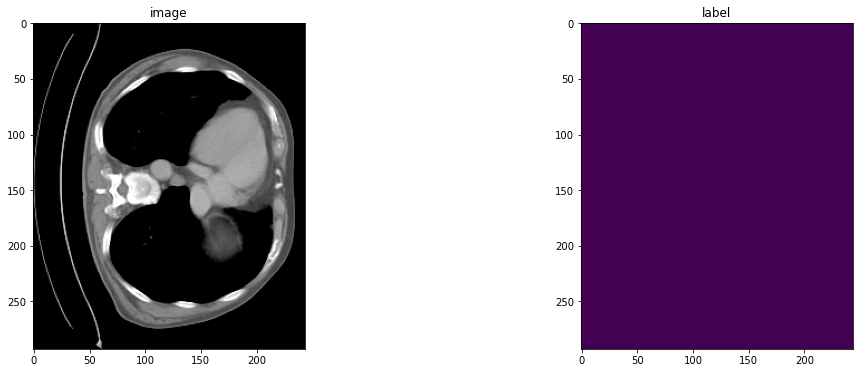

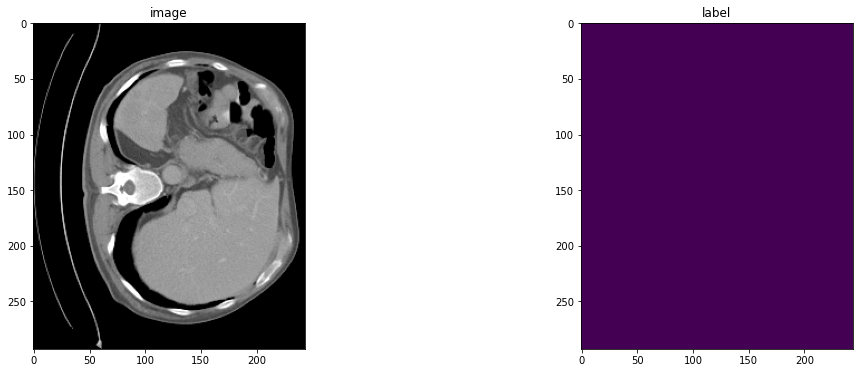

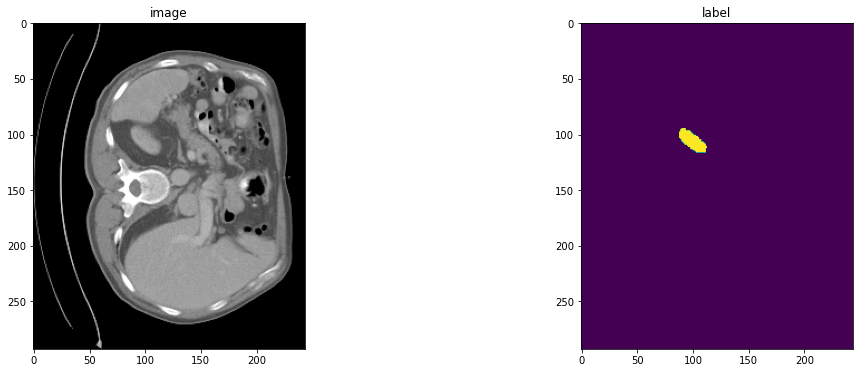

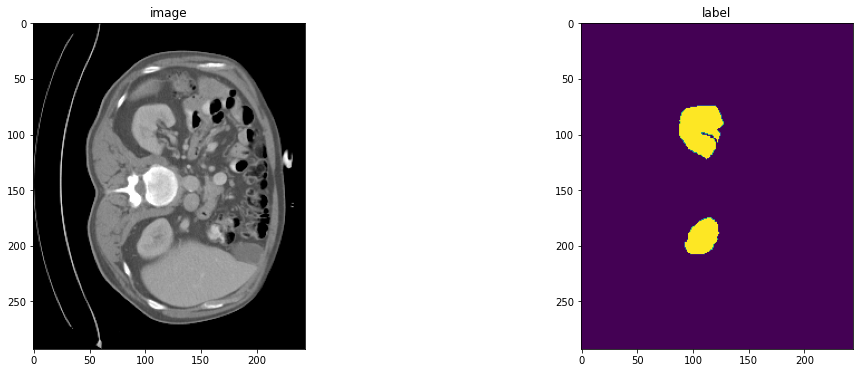

In [ ]:
case_num = 0
#img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
for i in range(0,4):
  plt.figure("image", (18, 6))
  plt.subplot(1, 2, 1)
  plt.title("image")
  plt.imshow(img[0, :, :, i*5+1].detach().cpu(), cmap="gray")
  plt.subplot(1, 2, 2)
  plt.title("label")
  plt.imshow(label[0, :, :, i*5+1].detach().cpu())
  plt.show()

In [ ]:
for val_image in val_loader:
  print(val_image['image'].shape)

torch.Size([1, 1, 293, 244, 38])
torch.Size([1, 1, 281, 259, 38])
torch.Size([1, 1, 278, 253, 38])
torch.Size([1, 1, 302, 253, 38])
torch.Size([1, 1, 246, 200, 38])
torch.Size([1, 1, 283, 254, 38])
torch.Size([1, 1, 296, 255, 38])
torch.Size([1, 1, 276, 262, 38])
torch.Size([1, 1, 285, 233, 38])
torch.Size([1, 1, 302, 287, 38])


torch.Size([8, 1, 96, 96, 32])


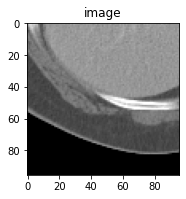

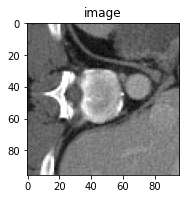

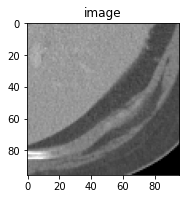

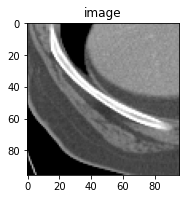

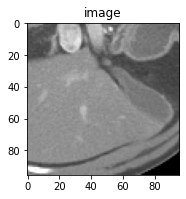

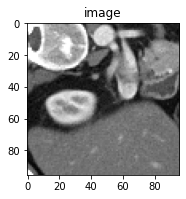

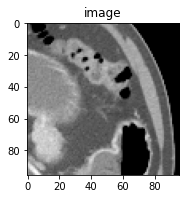

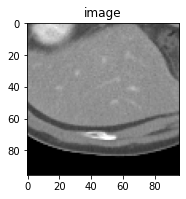

torch.Size([8, 1, 96, 96, 32])


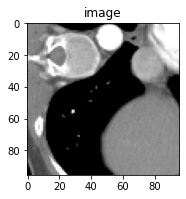

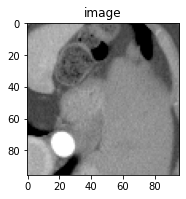

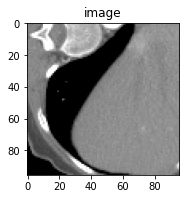

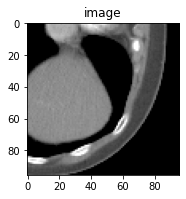

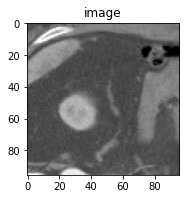

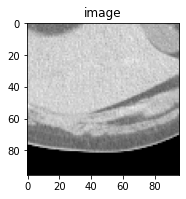

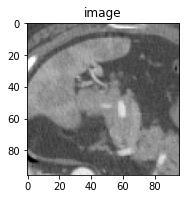

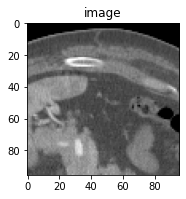

torch.Size([8, 1, 96, 96, 32])


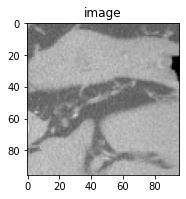

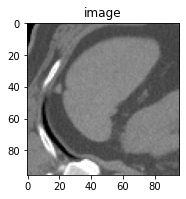

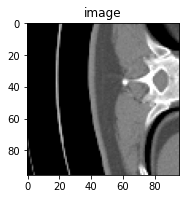

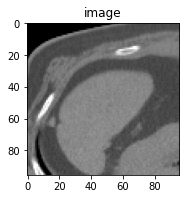

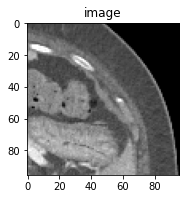

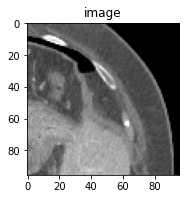

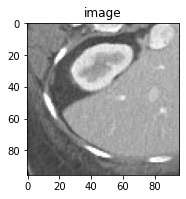

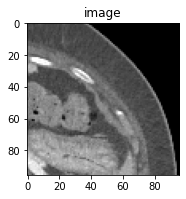

In [ ]:
j=0
for train_image in train_loader:
  print(train_image['image'].shape)
  for i in range(8):
    image=train_image['image'][i]
    plt.figure("check", (6,6))
    plt.subplot(1,2,1)
    plt.title("image")
    plt.imshow(image[0,:,:,0], cmap="gray")
    plt.show()
  j+=1
  if j==3:
    break

In [ ]:
device = torch.device("cuda:0")
!nvidia-smi

Wed Sep  1 19:09:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:01:00.0 Off |                  N/A |
| 37%   34C    P8    29W / 350W |   8865MiB / 24265MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# pip install einops

In [ ]:
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

in_channels=1,
    out_channels=3, #classes
    img_size=(96, 96, 32),
    feature_size=8, #16
    hidden_size=384, #768
    mlp_dim=1536, #3072
    num_heads=12,
    pos_embed="perceptron", #perceptron
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
    lr=1e-4, weight_decay=1e-5
    max_iterations = 50
    eval_num = 5
    train completed, best_metric: 0.0086 at iteration: 5
    //
        in_channels=1,
    out_channels=3, #classes
    img_size=(96, 96, 32),
    feature_size=8, #16
    hidden_size=384, #768
    mlp_dim=1536, #3072
    num_heads=12,
    pos_embed="perceptron", #perceptron
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
    lr=1e-5, weight_decay=1e-5
    max_iterations = 200
eval_num = 10
train completed, best_metric: 0.3352 at iteration: 200

In [ ]:
max_epochs = 500
val_interval = 10
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, n_classes=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, n_classes=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "0831_best_metric_model_v1.pth")) # change!!!!!!!!!!!!!!!!
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/500
1/15, train_loss: 0.6170
2/15, train_loss: 0.6350
3/15, train_loss: 0.6472
4/15, train_loss: 0.6472
5/15, train_loss: 0.6432
6/15, train_loss: 0.6507
7/15, train_loss: 0.6302
8/15, train_loss: 0.5999
9/15, train_loss: 0.6237
10/15, train_loss: 0.6253
11/15, train_loss: 0.6020
12/15, train_loss: 0.5882
13/15, train_loss: 0.6246
14/15, train_loss: 0.6257
15/15, train_loss: 0.6227
epoch 1 average loss: 0.6255
----------
epoch 2/500
1/15, train_loss: 0.6214
2/15, train_loss: 0.6118
3/15, train_loss: 0.6097
4/15, train_loss: 0.6097
5/15, train_loss: 0.5960
6/15, train_loss: 0.6054
7/15, train_loss: 0.6187
8/15, train_loss: 0.5882
9/15, train_loss: 0.5627
10/15, train_loss: 0.6118
11/15, train_loss: 0.6163
12/15, train_loss: 0.6258
13/15, train_loss: 0.5911
14/15, train_loss: 0.6071
15/15, train_loss: 0.5948
epoch 2 average loss: 0.6047
----------
epoch 3/500
1/15, train_loss: 0.6152
2/15, train_loss: 0.6077
3/15, train_loss: 0.6383
4/15, train_loss: 0.6195
5/15, train

In [ ]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.8756 at epoch: 390


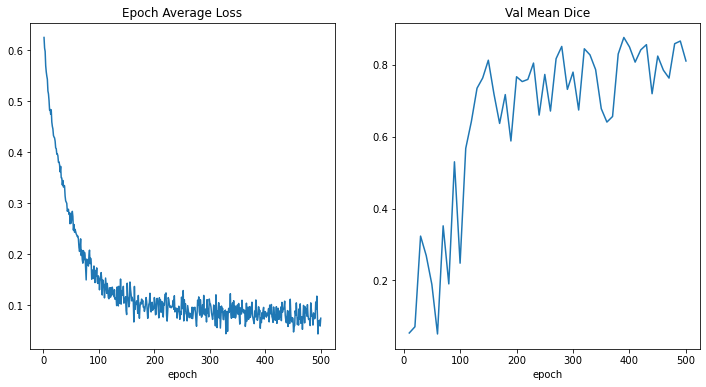

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [ ]:
out_dir='/Volumes/moai2021/result/naejung/20210831'
import nibabel as nib

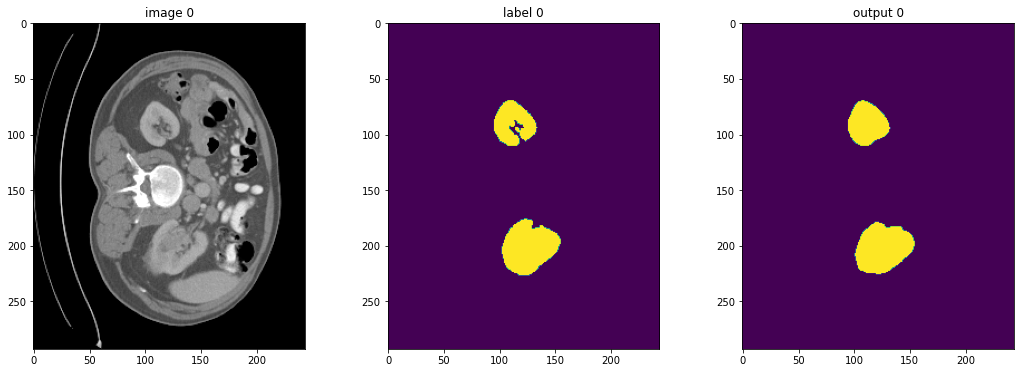

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "0831_best_metric_model_v1.pth"))) # change!!!!!!!!!!!
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        img = val_data["image"]
        val_inputs = torch.unsqueeze(img, 1).to(device)
        val_outputs_new=np.array(torch.argmax(val_outputs, dim=1).detach().cpu().numpy()[0],dtype=np.float64)
        ##print('#####')
        ##print(val_outputs_new)
        #print(val_data['image_meta_dict']['affine'][0][0])
        #h1=nib.Nifti1Image(val_inputs.cpu().numpy()[0],val_data['image_meta_dict']['affine'][0])
        #nib.save(h1,os.path.join(out_dir,f'val_{case_num}_image.nii.gz'))
        #h2=nib.Nifti1Image(val_outputs_new,val_data['image_meta_dict']['affine'][0])
        #nib.save(h2,os.path.join(out_dir,f'val_{case_num}_pred.nii.gz'))
        # plot the slice [:, :, 80]
        sl=20
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, sl], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, sl])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, sl])
        plt.show()
        if i==0:
            break

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [ ]:
#print(train_ds['label'][:,:200])

print(val_outputs) # 5D?
print(val_outputs_new) # 3D?
#print(torch.argmax(
          
          #  val_outputs, dim=1).detach().cpu()[0, :, :, sl])

tensor([[[[[ 4.8554,  4.6910,  4.9677,  ...,  4.4397,  4.9388,  4.7193],
           [ 4.0757,  5.3361,  4.3245,  ...,  5.1391,  4.1502,  5.3521],
           [ 5.2504,  5.1757,  5.3152,  ...,  5.2467,  5.3656,  5.2028],
           ...,
           [ 4.0132,  4.8174,  3.9380,  ...,  4.7842,  4.0371,  4.8578],
           [ 5.6646,  5.3695,  5.4783,  ...,  5.2673,  5.6928,  5.4454],
           [ 3.2987,  3.5653,  3.1292,  ...,  3.7772,  3.2338,  3.6362]],

          [[ 5.4912,  5.5425,  5.7156,  ...,  5.2368,  5.5246,  5.6215],
           [ 7.0035,  9.0006,  7.0691,  ...,  8.6012,  7.1136,  9.2583],
           [ 6.7790,  5.9356,  6.8835,  ...,  5.9138,  6.8501,  6.0564],
           ...,
           [ 6.6063,  7.8701,  6.6958,  ...,  7.3771,  6.7079,  8.0058],
           [ 6.4822,  6.9365,  6.5874,  ...,  7.2107,  6.5205,  7.0671],
           [ 5.5901,  5.3857,  5.4786,  ...,  5.4290,  5.6202,  5.5902]],

          [[ 5.4600,  4.9261,  5.5535,  ...,  4.7852,  5.5012,  5.0645],
           [ 6.

In [ ]:
from monai.transforms.utils import generate_spatial_bounding_box

a1,b1=generate_spatial_bounding_box(val_outputs_new[:,:150]) #check
a2,b2=generate_spatial_bounding_box(val_outputs_new[:,150:])

In [ ]:
print(a1,b1,a2,b2)

[0, 0] [150, 38] [0, 5] [34, 36]


In [ ]:
tmp1= val_outputs_new
tmp1[a1[0]:b1[0],a1[1]:b1[1]]=1
tmp1[(150+a2[0]):(150+b2[0]),a2[1]:b2[1]]=1
temp=val_data["image"][0][0]*tmp1

image shape: torch.Size([293, 244, 38]), label shape: (293, 244, 38)


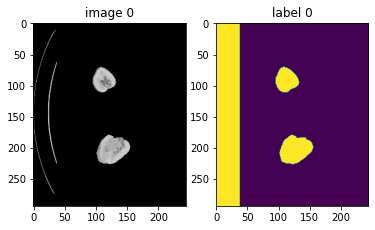

In [ ]:
img = temp
label = tmp1

img_shape = img.shape
label_shape = label.shape

print(f"image shape: {img_shape}, label shape: {label_shape}")

plt.subplot(1,2,1)
plt.title(f"image {i}")
plt.imshow(temp[:, :, sl], cmap="gray")
plt.subplot(1,2,2)
plt.title(f"label {i}")
plt.imshow(tmp1[:, :, sl])

STEP 2

In [ ]:
from monai.transforms.utils import generate_spatial_bounding_box

In [ ]:
class ConvertToMultiChannel(MapTransform):
    """
    Convert labels to multi channels:
    """
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            result.append(d[key].astype(np.int8) >0)
#            result.append(d[key].astype(np.int8) == 1)
#            result.append(d[key].astype(np.int8) == 2)
#            result.append(d[key].astype(np.int8) == 4)
            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d



def masked(data_dict):
    a1,b1=generate_spatial_bounding_box(data_dict['label'][:,:200]) #check
    a2,b2=generate_spatial_bounding_box(data_dict['label'][:,200:])
    tmp1= data_dict['label'][0]
    tmp1[a1[0]:b1[0],a1[1]:b1[1],a1[2]:b1[2]]=1
    tmp1[(200+a2[0]):(200+b2[0]),a2[1]:b2[1],a2[2]:b2[2]]=1
    data_dict["image"]=data_dict["image"]*tmp1
    return data_dict


train_transforms_step2 = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image"]),
        ConvertToMultiChannel(keys=["label"]), 
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.3, 1.3, 1.3), #check
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image"], axcodes="RAS"),
        Orientationd(keys=["label"], axcodes="RPS"),
        masked,
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-285,
            a_max=350,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
       
       # removed random agmentation
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms_step2 = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image"]),
        ConvertToMultiChannel(keys=["label"]), 
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.3, 1.3, 1.3), #check
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image"], axcodes="RAS"),
        Orientationd(keys=["label"], axcodes="RPS"),
        masked,
        ScaleIntensityRanged(
            keys=["image"], a_min=-285, a_max=350, b_min=0.0, b_max=1.0, clip=True
        ),
       
        ToTensord(keys=["image", "label"]),
    ]
)


In [ ]:
train_ds_2 = CacheDataset(
    data=train_f,
    transform=train_transforms_step2,
    cache_num=1, 
    # It is recommended to experiment with different cache_num or cache_rate to identify the best training speed.
    cache_rate=1.0,
    num_workers=0,
)
train_loader_2 = DataLoader(
    train_ds_2, batch_size=2, shuffle=True, num_workers=0, pin_memory=True
)

val_ds_2 = CacheDataset(
    data=val_f, transform=val_transforms_step2, cache_num=1, cache_rate=1.0, num_workers=0
)
val_loader_2 = DataLoader(
    val_ds_2, batch_size=1, shuffle=False, num_workers=0, pin_memory=True
)

In [ ]:
#a1,b1=generate_spatial_bounding_box(train_ds_2[0]['label'][:,:200].numpy()) #check
#a2,b2=generate_spatial_bounding_box(train_ds_2[0]['label'][:,200:].numpy())


In [ ]:
case_num = 0
#img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
img = train_ds_2[case_num]["image"]
label = train_ds_2[case_num]["label"]
#label[0,a1[0]:b1[0],a1[1]:b1[1],a1[2]:b1[2]]=1
img_shape = img.shape
label_shape = label.shape

print(f"image shape: {img_shape}, label shape: {label_shape}")
for i in range(0,4):
  plt.figure("image", (18, 6))
  plt.subplot(1, 2, 1)
  plt.title("image")
  plt.imshow(img[0, :, :, i*5+1].detach().cpu(), cmap="gray")
  plt.subplot(1, 2, 2)
  plt.title("label")
  plt.imshow(label[0, :, :, i*5+1].detach().cpu())
  plt.show()